# Field4D クラス入門

このノートブックでは、`gwexpy` の `Field4D` クラスの基本的な使い方を学びます。

## Field4D とは？

`Field4D` は、時間と3次元空間の4次元データを扱うための特殊なクラスです。物理場の時空間構造を表現し、以下の機能を提供します：

- **軸0（時間軸）**: 時間ドメイン ↔ 周波数ドメインの変換
- **軸1-3（空間軸）**: 実空間 ↔ K空間（波数空間）の変換
- **4D構造の保持**: スライシングしても常に4次元を維持
- **バッチ操作**: `Field4DList` と `Field4DDict` による複数フィールドの一括処理


## セットアップ

必要なライブラリをインポートします。


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u

from gwexpy.types import Field4D, Field4DDict, Field4DList

# 再現性のためのシード設定
np.random.seed(42)

## 1. Field4D の初期化とメタデータ

`Field4D` オブジェクトを作成し、そのメタデータを確認します。


In [2]:
# 4Dデータの作成（10時点 × 8×8×8 の空間グリッド）
nt, nx, ny, nz = 10, 8, 8, 8
data = np.random.randn(nt, nx, ny, nz)

# 軸座標の定義
t = np.arange(nt) * 0.1 * u.s
x = np.arange(nx) * 0.5 * u.m
y = np.arange(ny) * 0.5 * u.m
z = np.arange(nz) * 0.5 * u.m

# Field4D オブジェクトの作成
field = Field4D(
    data,
    unit=u.V,
    axis0=t,
    axis1=x,
    axis2=y,
    axis3=z,
    axis_names=["t", "x", "y", "z"],
    axis0_domain="time",
    space_domain="real"
)

print(f"Shape: {field.shape}")
print(f"Unit: {field.unit}")
print(f"Axis names: {field.axis_names}")
print(f"Axis0 domain: {field.axis0_domain}")
print(f"Space domains: {field.space_domains}")

Shape: (10, 8, 8, 8)
Unit: V
Axis names: ('t', 'x', 'y', 'z')
Axis0 domain: time
Space domains: {'x': 'real', 'y': 'real', 'z': 'real'}


### メタデータの確認

- `axis0_domain`: 軸0のドメイン（"time" または "frequency"）
- `space_domains`: 各空間軸のドメイン（"real" または "k"）
- `axis_names`: 各軸の名前

これらのメタデータは、FFT変換時に自動的に更新されます。


## 2. 4D構造を保持するスライシング

`Field4D` の重要な特徴は、**スライシングしても常に4次元を維持する**ことです。
整数インデックスを使っても、自動的に長さ1のスライスに変換されます。


In [3]:
# 整数インデックスでスライス（通常のndarrayなら3Dになる）
sliced = field[0, :, :, :]

print(f"Original shape: {field.shape}")
print(f"Sliced shape: {sliced.shape}")  # (1, 8, 8, 8) - 4Dを維持！
print(f"Type: {type(sliced)}")  # Field4D のまま
print(f"Axis names preserved: {sliced.axis_names}")

Original shape: (10, 8, 8, 8)
Sliced shape: (1, 8, 8, 8)
Type: <class 'gwexpy.types.field4d.Field4D'>
Axis names preserved: ('t', 'x', 'y', 'z')


In [4]:
# 複数の軸で整数インデックスを使用
sliced_multi = field[0, 1, 2, 3]

print(f"Multi-sliced shape: {sliced_multi.shape}")  # (1, 1, 1, 1) - やはり4D
print(f"Value: {sliced_multi.value}")

Multi-sliced shape: (1, 1, 1, 1)
Value: [[[[-0.51827022]]]]


この挙動により、Field4Dオブジェクトの一貫性が保たれ、メタデータ（軸名やドメイン情報）が失われることがありません。


## 3. 時間-周波数変換（軸0のFFT）

`fft_time()` と `ifft_time()` メソッドを使って、時間軸を周波数軸に変換できます。
GWpy の `TimeSeries.fft()` と同じ正規化を採用しています。


In [5]:
# 時間ドメインのField4Dを作成（正弦波）
t_dense = np.arange(128) * 0.01 * u.s
x_small = np.arange(4) * 1.0 * u.m
signal_freq = 10.0  # Hz

# 10 Hz の正弦波を空間的に均一に配置
data_signal = np.sin(2 * np.pi * signal_freq * t_dense.value)[:, None, None, None]
data_signal = np.tile(data_signal, (1, 4, 4, 4))

field_time = Field4D(
    data_signal,
    unit=u.V,
    axis0=t_dense,
    axis1=x_small,
    axis2=x_small.copy(),
    axis3=x_small.copy(),
    axis_names=["t", "x", "y", "z"],
    axis0_domain="time",
    space_domain="real"
)

# FFT実行
field_freq = field_time.fft_time()

print(f"Time domain shape: {field_time.shape}")
print(f"Frequency domain shape: {field_freq.shape}")
print(f"Axis0 domain changed: {field_time.axis0_domain} → {field_freq.axis0_domain}")

Time domain shape: (128, 4, 4, 4)
Frequency domain shape: (65, 4, 4, 4)
Axis0 domain changed: time → frequency


/tmp/ipykernel_2244515/3020192017.py:15: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) FreeSans.
  plt.tight_layout()
/tmp/ipykernel_2244515/3020192017.py:15: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from font(s) FreeSans.
  plt.tight_layout()
/tmp/ipykernel_2244515/3020192017.py:15: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from font(s) FreeSans.
  plt.tight_layout()
/tmp/ipykernel_2244515/3020192017.py:15: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from font(s) FreeSans.
  plt.tight_layout()


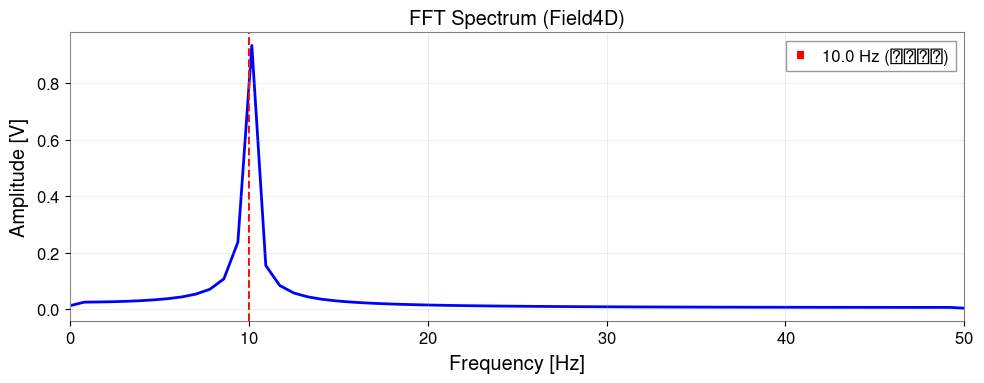

Peak frequency: 10.16 Hz (expected: 10.0 Hz)


In [6]:
# 周波数スペクトルをプロット（1点のx,y,zを選択）
# Note: スライスしても4D構造が維持されるため、squeeze()で次元を削減
spectrum = np.abs(field_freq[:, 0, 0, 0].value).squeeze()
freqs = field_freq._axis0_index.value

plt.figure(figsize=(10, 4))
plt.plot(freqs, spectrum, 'b-', linewidth=2)
plt.axvline(signal_freq, color='r', linestyle='--', label=f'{signal_freq} Hz (入力信号)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [V]')
plt.title('FFT Spectrum (Field4D)')
plt.xlim(0, 50)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ピーク周波数を確認
peak_idx = np.argmax(spectrum)
peak_freq = freqs[peak_idx]
print(f"Peak frequency: {peak_freq:.2f} Hz (expected: {signal_freq} Hz)")

### 逆FFT（周波数 → 時間）

`ifft_time()` で元の時間ドメインに戻すことができます。


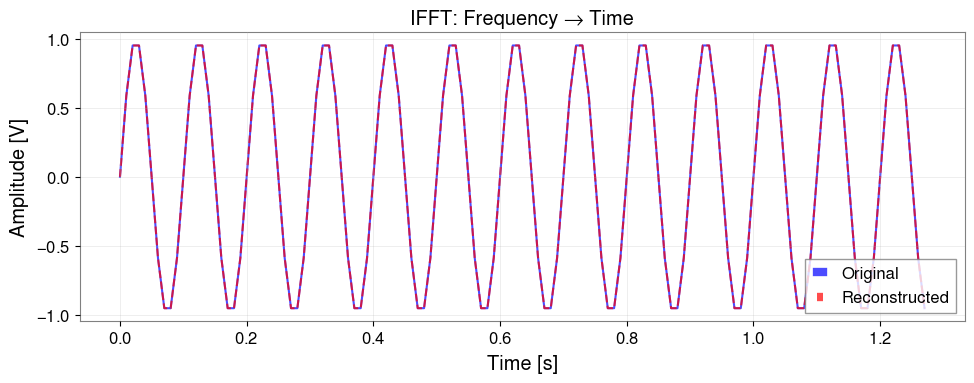

Max reconstruction error: 4.44e-16 V


In [7]:
# 逆FFT
field_reconstructed = field_freq.ifft_time()

# 元の信号と比較
# Note: 4D構造を維持するため、squeeze()で1次元に
original = field_time[:, 0, 0, 0].value.squeeze()
reconstructed = field_reconstructed[:, 0, 0, 0].value.squeeze()

plt.figure(figsize=(10, 4))
plt.plot(t_dense.value, original, 'b-', label='Original', alpha=0.7)
plt.plot(t_dense.value, reconstructed.real, 'r--', label='Reconstructed', alpha=0.7)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [V]')
plt.title('IFFT: Frequency → Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 誤差を確認
error = np.abs(original - reconstructed.real)
print(f"Max reconstruction error: {np.max(error):.2e} V")

## 4. 実空間-K空間変換（空間軸のFFT）

`fft_space()` と `ifft_space()` を使って、空間軸を波数空間（K空間）に変換できます。
角波数 k = 2π / λ の符号付きFFTを使用します。


In [8]:
# 空間的に周期構造を持つデータを作成
nx, ny, nz = 16, 16, 16
x_grid = np.arange(nx) * 0.5 * u.m
y_grid = np.arange(ny) * 0.5 * u.m
z_grid = np.arange(nz) * 0.5 * u.m

# X方向に波長 4m の正弦波
wavelength = 4.0  # m
k_expected = 2 * np.pi / wavelength  # rad/m

data_spatial = np.sin(2 * np.pi * x_grid.value / wavelength)[None, :, None, None]
data_spatial = np.tile(data_spatial, (4, 1, ny, nz))

field_real = Field4D(
    data_spatial,
    unit=u.V,
    axis0=np.arange(4) * 0.1 * u.s,
    axis1=x_grid,
    axis2=y_grid,
    axis3=z_grid,
    axis_names=["t", "x", "y", "z"],
    axis0_domain="time",
    space_domain="real"
)

# X軸のみFFT
field_kx = field_real.fft_space(axes=["x"])

print(f"Original space domains: {field_real.space_domains}")
print(f"After fft_space: {field_kx.space_domains}")
print(f"Axis names: {field_kx.axis_names}")

Original space domains: {'x': 'real', 'y': 'real', 'z': 'real'}
After fft_space: {'y': 'real', 'z': 'real', 'kx': 'k'}
Axis names: ('t', 'kx', 'y', 'z')


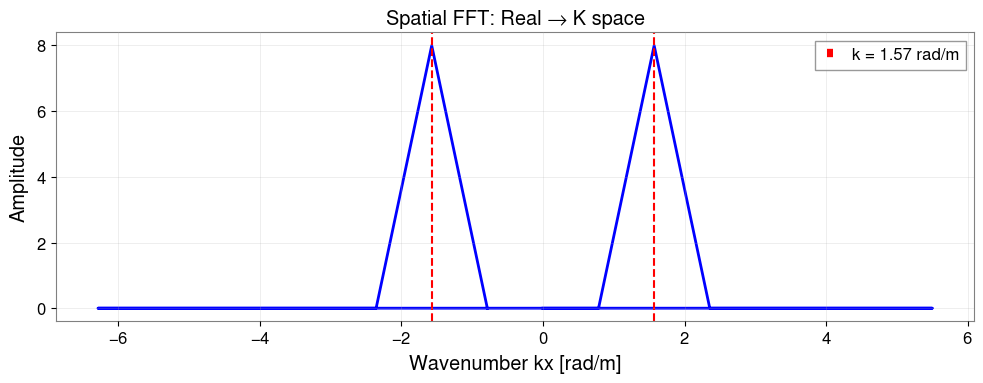

Peak wavenumber: 1.57 rad/m (expected: ±1.57 rad/m)


In [9]:
# K空間スペクトルをプロット
# Note: squeeze()で次元削減
kx_spectrum = np.abs(field_kx[0, :, 0, 0].value).squeeze()
kx_values = field_kx._axis1_index.value

plt.figure(figsize=(10, 4))
plt.plot(kx_values, kx_spectrum, 'b-', linewidth=2)
plt.axvline(k_expected, color='r', linestyle='--', label=f'k = {k_expected:.2f} rad/m')
plt.axvline(-k_expected, color='r', linestyle='--')
plt.xlabel('Wavenumber kx [rad/m]')
plt.ylabel('Amplitude')
plt.title('Spatial FFT: Real → K space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ピーク波数を確認
peak_idx = np.argmax(kx_spectrum)
peak_k = kx_values[peak_idx]
print(f"Peak wavenumber: {peak_k:.2f} rad/m (expected: ±{k_expected:.2f} rad/m)")

### 波長の計算

K空間では、`wavelength()` メソッドで波長を計算できます。


In [10]:
# 波長を計算
wavelengths = field_kx.wavelength("kx")

print(f"Wavelength at k={k_expected:.2f}: {2*np.pi/k_expected:.2f} m")
print(f"Calculated wavelengths range: {wavelengths.value[wavelengths.value > 0].min():.2f} - {wavelengths.value[wavelengths.value < np.inf].max():.2f} m")

Wavelength at k=1.57: 4.00 m
Calculated wavelengths range: 1.00 - 8.00 m


### 全空間軸のFFT

`axes` パラメータを省略すると、全空間軸をまとめてFFTできます。


In [11]:
# 全空間軸をFFT
field_k_all = field_real.fft_space()
print(f"All spatial axes in K space: {field_k_all.space_domains}")

# 逆FFTで元に戻す
field_real_back = field_k_all.ifft_space()
print(f"Back to real space: {field_real_back.space_domains}")

# 再構成誤差
reconstruction_error = np.max(np.abs(field_real.value - field_real_back.value))
print(f"Max reconstruction error: {reconstruction_error:.2e}")

All spatial axes in K space: {'kx': 'k', 'ky': 'k', 'kz': 'k'}
Back to real space: {'x': 'real', 'y': 'real', 'z': 'real'}
Max reconstruction error: 2.29e-16


## 5. Field4DList と Field4DDict によるバッチ操作

複数の `Field4D` オブジェクトをまとめて処理するには、`Field4DList` または `Field4DDict` を使用します。


### Field4DList

リスト形式で複数のフィールドを管理し、一括でFFT操作を適用できます。


In [12]:
# 3つの異なる振幅を持つField4Dを作成
amplitudes = [1.0, 2.0, 3.0]
fields = []

for amp in amplitudes:
    data_temp = amp * np.random.randn(8, 4, 4, 4)
    field_temp = Field4D(
        data_temp,
        unit=u.V,
        axis0=np.arange(8) * 0.1 * u.s,
        axis1=np.arange(4) * 0.5 * u.m,
        axis2=np.arange(4) * 0.5 * u.m,
        axis3=np.arange(4) * 0.5 * u.m,
        axis_names=["t", "x", "y", "z"],
        axis0_domain="time",
        space_domain="real"
    )
    fields.append(field_temp)

# Field4DList を作成
field_list = Field4DList(fields, validate=True)
print(f"Number of fields: {len(field_list)}")

Number of fields: 3


In [13]:
# 一括で時間FFTを実行
field_list_freq = field_list.fft_time_all()

print("All fields transformed to frequency domain:")
for i, field in enumerate(field_list_freq):
    print(f"  Field {i}: axis0_domain = {field.axis0_domain}")

All fields transformed to frequency domain:
  Field 0: axis0_domain = frequency
  Field 1: axis0_domain = frequency
  Field 2: axis0_domain = frequency


### Field4DDict

辞書形式で名前付きフィールドを管理します。


In [14]:
# 名前付きフィールドの辞書を作成
field_dict = Field4DDict({
    "channel_A": fields[0],
    "channel_B": fields[1],
    "channel_C": fields[2]
}, validate=True)

print(f"Field names: {list(field_dict.keys())}")

Field names: ['channel_A', 'channel_B', 'channel_C']


In [15]:
# 一括で空間FFTを実行
field_dict_k = field_dict.fft_space_all(axes=["x", "y"])

for name, field in field_dict_k.items():
    print(f"{name}: {field.space_domains}")

channel_A: {'z': 'real', 'kx': 'k', 'ky': 'k'}
channel_B: {'z': 'real', 'kx': 'k', 'ky': 'k'}
channel_C: {'z': 'real', 'kx': 'k', 'ky': 'k'}


## 6. 数値的不変量の検証

FFT変換の正確性を検証するため、往復変換（round-trip）が元のデータを再構成できることを確認します。


In [16]:
# 時間FFTの不変量チェック: ifft_time(fft_time(f)) ≈ f
np.random.seed(42)
data_test = np.random.randn(64, 4, 4, 4)
field_test = Field4D(
    data_test,
    unit=u.V,
    axis0=np.arange(64) * 0.01 * u.s,
    axis1=np.arange(4) * u.m,
    axis2=np.arange(4) * u.m,
    axis3=np.arange(4) * u.m,
    axis_names=['t', 'x', 'y', 'z'],
    axis0_domain='time',
    space_domain='real'
)

# Round-trip
field_roundtrip = field_test.fft_time().ifft_time()

# Check
max_error_time = np.max(np.abs(field_test.value - field_roundtrip.value.real))
print(f'時間FFT Round-trip max error: {max_error_time:.2e}')
assert max_error_time < 1e-10, 'Time FFT round-trip failed!'
print('✅ 時間FFT不変量チェック: PASSED')

時間FFT Round-trip max error: 9.99e-16
✅ 時間FFT不変量チェック: PASSED


In [17]:
# 空間FFTの不変量チェック: ifft_space(fft_space(f)) ≈ f
field_space_roundtrip = field_test.fft_space().ifft_space()

max_error_space = np.max(np.abs(field_test.value - field_space_roundtrip.value.real))
print(f'空間FFT Round-trip max error: {max_error_space:.2e}')
assert max_error_space < 1e-10, 'Space FFT round-trip failed!'
print('✅ 空間FFT不変量チェック: PASSED')

空間FFT Round-trip max error: 8.88e-16
✅ 空間FFT不変量チェック: PASSED


In [18]:
# K軸の規約チェック: 両側（正負）の波数を持つこと
field_k = field_test.fft_space(axes=['x'])
kx_values = field_k._axis1_index.value

has_negative = np.any(kx_values < 0)
has_positive = np.any(kx_values > 0)
has_zero = np.any(kx_values == 0)

print(f'K軸に負の値: {has_negative}')
print(f'K軸に正の値: {has_positive}')
print(f'K軸にゼロ: {has_zero}')
assert has_negative and has_positive and has_zero, 'K-axis should have positive, negative, and zero values!'
print('✅ K軸両側規約チェック: PASSED')

K軸に負の値: True
K軸に正の値: True
K軸にゼロ: True
✅ K軸両側規約チェック: PASSED


In [19]:
# 波長計算の規約チェック: k=0 のとき wavelength = inf
wavelengths = field_k.wavelength('kx')
zero_k_idx = np.where(kx_values == 0)[0]

if len(zero_k_idx) > 0:
    wavelength_at_zero = wavelengths.value.flat[zero_k_idx[0]]
    print(f'k=0 における波長: {wavelength_at_zero}')
    assert np.isinf(wavelength_at_zero), 'Wavelength at k=0 should be inf!'
    print('✅ k=0 波長チェック: PASSED')
else:
    print('(k=0 が軸に含まれていないためスキップ)')

k=0 における波長: inf
✅ k=0 波長チェック: PASSED


## 7. まとめ

このノートブックでは、`Field4D` の主要な機能を学びました：

1. **初期化とメタデータ**: 軸情報とドメイン情報の管理
2. **4D保持スライシング**: 整数インデックスでも4D構造を維持
3. **時間-周波数変換**: `fft_time()` / `ifft_time()` による軸0のFFT
4. **実空間-K空間変換**: `fft_space()` / `ifft_space()` による空間軸のFFT
5. **バッチ操作**: `Field4DList` と `Field4DDict` による複数フィールドの一括処理

これらの機能を組み合わせることで、時空間データの高度な解析が可能になります。

### 次のステップ

- より複雑な物理シミュレーションへの応用
- 実データとの組み合わせ
- カスタム解析パイプラインの構築
